In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [51]:
df_train = pd.read_csv("gs://aura_datasets_training_validation/AURA_aug_sep_60k.csv")
df_val = pd.read_csv("gs://aura_datasets_training_validation/AURA_validation_sep_12k.csv")

In [52]:
feature_cols = ["noise_db", "light_lux", "crowd_count"]
target_col = "comfort_label"

X_train = df_train[feature_cols]
y_train = df_train[target_col]

X_val = df_val[feature_cols]
y_val = df_val[target_col]

In [53]:
# Label encode the comfort_label
le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_val_encoded = le.transform(y_val)

## Preparing pipeline for scaling

In [54]:
# Preprocessing: scale numeric features
numeric_features = feature_cols
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ],
    remainder="drop"
)

## Building model and pipeline

In [61]:
# Base model
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

# Full pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", log_reg)
])

## Hyperparameter grid search

In [73]:
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train_encoded)

print("Best params:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best params: {'clf__C': 10, 'clf__class_weight': None}
Best CV accuracy: 0.9452166666666667


## Evaluate on validation set

In [63]:
best_pipe = grid_search.best_estimator_

y_val_pred_encoded = best_pipe.predict(X_val)
y_val_pred = le.inverse_transform(y_val_pred_encoded)

print("Validation accuracy:", accuracy_score(y_val_encoded, y_val_pred_encoded))
print(classification_report(y_val, y_val_pred))

Validation accuracy: 0.9496666666666667
                  precision    recall  f1-score   support

     comfortable       0.99      0.99      0.99      2400
         neutral       0.96      0.93      0.94      2400
        stressed       0.93      0.94      0.93      2400
   uncomfortable       0.88      0.89      0.88      2400
very_comfortable       1.00      1.00      1.00      2400

        accuracy                           0.95     12000
       macro avg       0.95      0.95      0.95     12000
    weighted avg       0.95      0.95      0.95     12000



Confusion matrix (raw counts):
[[2382    7    0    0   11]
 [  14 2231    0  155    0]
 [   0    0 2256  144    0]
 [   0   93  180 2127    0]
 [   0    0    0    0 2400]]
Class order: ['comfortable' 'neutral' 'stressed' 'uncomfortable' 'very_comfortable']


<Figure size 600x500 with 0 Axes>

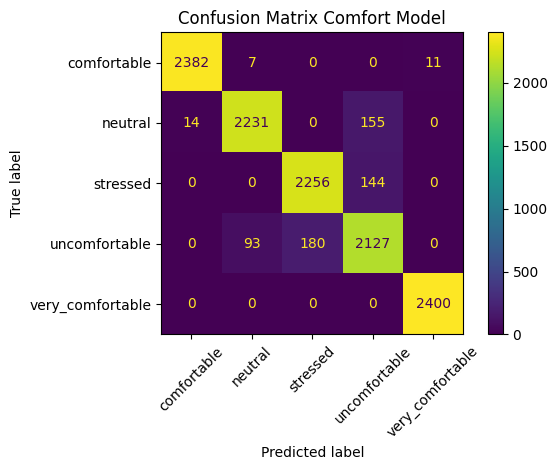

In [72]:
# Evaluate via confudion matric
cm = confusion_matrix(y_val_encoded, y_val_pred_encoded)

class_names = le.classes_

print("Confusion matrix (raw counts):")
print(cm)
print("Class order:", class_names)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d")  # integer counts
plt.title("Confusion Matrix Comfort Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

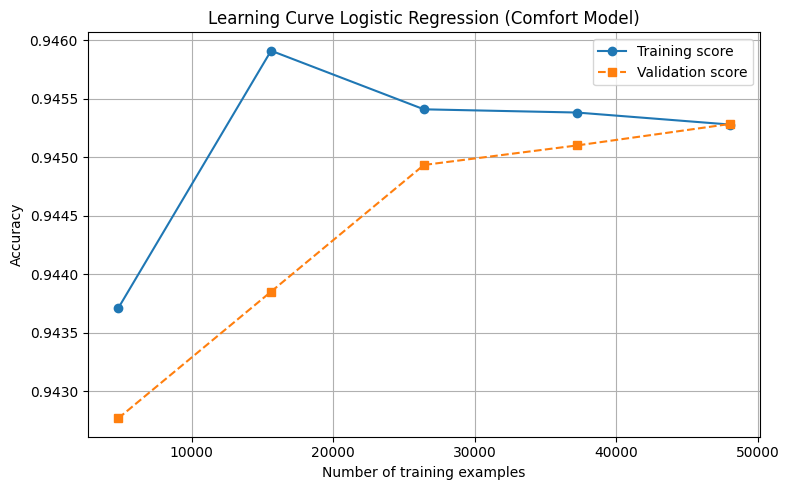

In [ ]:
# Evaluate via learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_pipe,
    X=X_train,
    y=y_train_encoded,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(8, 5))
plt.title("Learning Curve Logistic Regression (Comfort Model)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.grid(True)

plt.plot(train_sizes, train_mean, marker="o", label="Training score")

plt.plot(train_sizes, val_mean, marker="s", linestyle="--", label="Validation score")

plt.legend(loc="best")
plt.tight_layout()
plt.show()